Get the data from the google drive. You need to update this based on where your data is in the google drive

In [1]:
import os
DATA_DRIVE = 'data'
DRIVE_PATH = os.path.join('/storage/ice1/6/1/ssubedi33', DATA_DRIVE)
print(os.listdir(DRIVE_PATH))

['.idea', 'LICENSE.txt', 'test_seen.jsonl', 'img', 'test.jsonl', 'README.md', 'dev_seen.jsonl', 'dev.jsonl', '.DS_Store', 'train.jsonl']


Import torch and reload external modules

In [2]:
# Just run this block. Please do not modify the following code.
import pandas as pd
import torch

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [3]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


Load data here. train.jsonl and dev.jsonl file contains id, image location, label and caption in the image.

In [4]:
path = DRIVE_PATH + '/train.jsonl'
train_data=pd.read_json(path,lines=True)
print(f"Train set size: {len(train_data)}")

Train set size: 8500


In [5]:
path = DRIVE_PATH + '/dev_seen.jsonl'
val_data=pd.read_json(path,lines=True)
print(f"Test set size: {len(val_data)}")

Test set size: 500


In [6]:
path = DRIVE_PATH + '/test_seen.jsonl'
test_data=pd.read_json(path,lines=True)
print(f"Test set size: {len(test_data)}")

Test set size: 1000


Split train data in to train, validation set. dev data will be test set.

In [7]:
from sklearn.model_selection import train_test_split

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(test_data.head())


Train set size: 8500
Validation set size: 500
Test set size: 1000
      id            img  label                                         text
0  16395  img/16395.png      1                     handjobs sold seperately
1  37405  img/37405.png      1         introducing fidget spinner for women
2  94180  img/94180.png      1  happy pride month let's go beat up lesbians
3  54321  img/54321.png      1       laughs in [majority of u.s crime rate]
4  97015  img/97015.png      1       finds out those 72 virgins.. are goats


Fine Tuning CLIP model.
This part of the code imports the pretrained model and processor from openAI.
model contains weights and actual architecture.
processor contains tokenizer for words and feature extractor for image. These are used to convert image and caption into numbers that computer will understand.


In [10]:
from transformers import CLIPModel, CLIPProcessor

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


This is a class to tokenize dataset. It takes an input and output tokens for text and image. It uses the same tokenizer that CLIP uses.

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class MemeDataset(Dataset):
    def __init__(self, dataframe, processor, image_root_dir, max_length = 70):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        #directory where all images are
        self.image_root = image_root_dir
        #to make sure all captions are of same length
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #get the data at idx
        row = self.df.loc[idx]
        #extract path to image
        img_path = f"{self.image_root}/{row['img'].split('/')[-1]}"
        #load image in RGB
        image = Image.open(img_path).convert("RGB")
        #load text
        text = row['text']
        #load label
        label = torch.tensor(row['label'], dtype=torch.float)

        # Convert text and image to tokens
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_length,
            truncation=True)

        # Remove batch dimension (1) from processor outputs
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        #add label
        inputs["labels"] = label
        return inputs


Implement MemeDataset class to the train data, validation data, and test data.

In [12]:
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 32
train_dataset = MemeDataset(train_data, processor, image_root_dir = DRIVE_PATH + "/img")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = MemeDataset(val_data, processor, image_root_dir = DRIVE_PATH + "/img")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = MemeDataset(test_data, processor, image_root_dir = DRIVE_PATH + "/img")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Binary classification head at the end of CLIP model. It uses CLIP embeddings from both text and image inputs, and combines them to make a prediction.


In [13]:
import torch.nn as nn

class CLIPBinaryClassifier(nn.Module):
    def __init__(self, clip_model, dropout_prob=0.3):
        super().__init__()
        self.clip = clip_model
        dim = self.clip.config.projection_dim
        
        # Enhanced Image Classifier
        self.image_classifier = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.BatchNorm1d(dim*2),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(dim*2, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(dim, 1))
        
        # Enhanced Text Classifier
        self.text_classifier = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.LayerNorm(dim*2),
            nn.GELU(),
            nn.Dropout(dropout_prob), 
            nn.Linear(dim*2, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(dim, 1))
        
        
        # Weight initialization
        self._init_weights()
        
        # Weight for ensembling
        self.alpha = nn.Parameter(torch.tensor(0.5))
        
    def _init_weights(self):
        for module in [self.image_classifier, self.text_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight)
                    nn.init.zeros_(layer.bias)
    
    def forward(self, input_ids, attention_mask, pixel_values):
        with torch.no_grad():
            outputs = self.clip(input_ids=input_ids, 
                              attention_mask=attention_mask, 
                              pixel_values=pixel_values)
        
        image_emb = outputs.image_embeds
        text_emb = outputs.text_embeds
        
        # Individual predictions
        image_logits = self.image_classifier(image_emb)
        text_logits = self.text_classifier(text_emb)
        
        #Ensemble with learnable weight (sigmoid to keep between 0 and 1)
        weight = torch.sigmoid(self.alpha)
        combined = weight * image_logits + (1 - weight) * text_logits
        return {'combined': combined.squeeze(-1), 'image': image_logits.squeeze(-1), 'text': text_logits.squeeze(-1)}

This runs the training loop. 

Epoch 1/15: 100%|██████████| 266/266 [07:35<00:00,  1.71s/it, loss=0.899]


Epoch 1 | Train Loss: 0.7709 | Val Loss: 0.9381 | Train AUC: 0.7586 | Val AUC: 0.7177


Epoch 2/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.68] 


Epoch 2 | Train Loss: 0.5965 | Val Loss: 0.9657 | Train AUC: 0.8663 | Val AUC: 0.7229


Epoch 3/15: 100%|██████████| 266/266 [05:04<00:00,  1.14s/it, loss=0.49] 


Epoch 3 | Train Loss: 0.4992 | Val Loss: 1.0363 | Train AUC: 0.9108 | Val AUC: 0.7413


Epoch 4/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.396]


Epoch 4 | Train Loss: 0.3945 | Val Loss: 1.1662 | Train AUC: 0.9492 | Val AUC: 0.7378


Epoch 5/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.403]


Epoch 5 | Train Loss: 0.3288 | Val Loss: 1.0344 | Train AUC: 0.9650 | Val AUC: 0.7440


Epoch 6/15: 100%|██████████| 266/266 [05:01<00:00,  1.13s/it, loss=0.438]


Epoch 6 | Train Loss: 0.2594 | Val Loss: 1.2407 | Train AUC: 0.9795 | Val AUC: 0.7498


Epoch 7/15: 100%|██████████| 266/266 [05:01<00:00,  1.13s/it, loss=0.163] 


Epoch 7 | Train Loss: 0.2121 | Val Loss: 1.3595 | Train AUC: 0.9868 | Val AUC: 0.7458


Epoch 8/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.356] 


Epoch 8 | Train Loss: 0.1665 | Val Loss: 1.4784 | Train AUC: 0.9917 | Val AUC: 0.7476


Epoch 9/15: 100%|██████████| 266/266 [05:01<00:00,  1.13s/it, loss=0.133] 


Epoch 9 | Train Loss: 0.1470 | Val Loss: 1.6405 | Train AUC: 0.9935 | Val AUC: 0.7446


Epoch 10/15: 100%|██████████| 266/266 [05:01<00:00,  1.13s/it, loss=0.0616]


Epoch 10 | Train Loss: 0.1214 | Val Loss: 1.7255 | Train AUC: 0.9950 | Val AUC: 0.7391


Epoch 11/15: 100%|██████████| 266/266 [05:01<00:00,  1.13s/it, loss=0.0442]


Epoch 11 | Train Loss: 0.1023 | Val Loss: 2.0798 | Train AUC: 0.9966 | Val AUC: 0.7348


Epoch 12/15: 100%|██████████| 266/266 [05:13<00:00,  1.18s/it, loss=0.031] 


Epoch 12 | Train Loss: 0.0912 | Val Loss: 1.9927 | Train AUC: 0.9971 | Val AUC: 0.7507


Epoch 13/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.0603]


Epoch 13 | Train Loss: 0.0833 | Val Loss: 1.9081 | Train AUC: 0.9975 | Val AUC: 0.7381


Epoch 14/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.107]  


Epoch 14 | Train Loss: 0.0727 | Val Loss: 1.8677 | Train AUC: 0.9980 | Val AUC: 0.7426


Epoch 15/15: 100%|██████████| 266/266 [05:03<00:00,  1.14s/it, loss=0.0422] 


Epoch 15 | Train Loss: 0.0787 | Val Loss: 2.0825 | Train AUC: 0.9973 | Val AUC: 0.7390


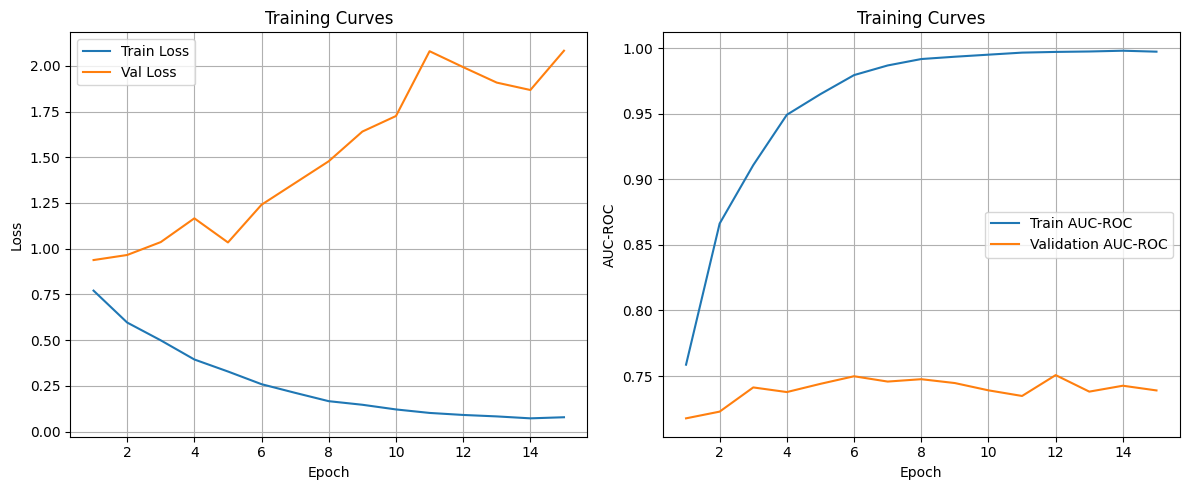

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score 
from tqdm import tqdm  # For progress bars

# Initialize classifier, takes the CLIP model and dropout probability as input
classifier = CLIPBinaryClassifier(model, dropout_prob=0.2).to(device)

# Freeze CLIP backbone, to make the model faster
for param in classifier.clip.parameters():
    param.requires_grad = False

# Optimizer - now includes all trainable parameters (classifiers + alpha)
learning_rate = 0.0001
#reduce the learning rate for alpha
optimizer = torch.optim.AdamW([{'params': classifier.image_classifier.parameters()}, {'params': classifier.text_classifier.parameters()}, {'params': [classifier.alpha], 'lr': learning_rate * 0.1}], lr=learning_rate)

# Cross entropy Loss and epochs
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([65/35], device=device))
epochs = 15

# Track losses, auc scores and alpha
train_losses = []
val_losses = []
ensemble_weights = [] 
train_auc_scores = []
val_auc_scores = []

# Training loop
for epoch in range(epochs):
    #Train classifier
    classifier.train()
    #Initialize loss
    total_train_loss = 0
    #Initialize logits for AUCROC
    train_logits = []
    train_labels = []
    #shows the progress bar 
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for batch in progress_bar:
        # Move data to cuda for training
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = classifier(input_ids, attention_mask, pixel_values)
        logits = outputs['combined']
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track stats
        total_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
                               
        # Collect logits and labels, first stack into 1 tensor
        train_logits.append(logits.detach().cpu())
        train_labels.append(labels.detach().cpu())
     
    # Compute train AUC-ROC
    train_preds = torch.cat(train_logits).numpy()
    train_targets = torch.cat(train_labels).numpy()
    train_auc = roc_auc_score(train_targets, train_preds)
    train_auc_scores.append(train_auc)
    
    # Validation
    classifier.eval()
    total_val_loss = 0
    val_logits = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            #Run the model
            outputs = classifier(input_ids, attention_mask, pixel_values)
            logits = outputs['combined']
            loss = criterion(logits, labels)
            total_val_loss += loss.item()
    
            #logits and labels to cpu
            val_logits.append(logits.cpu())
            val_labels.append(labels.cpu())
    
    #validation AUC-ROC, first stack into 1 tensor
    val_preds = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_labels).numpy()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_auc_scores.append(val_auc)
                               
    # Save epoch metrics
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    #Print Epoch metrics
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train AUC: {train_auc:.4f} | "
          f"Val AUC: {val_auc:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(True)

#AUC-ROC plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_auc_scores, label='Train AUC-ROC')
plt.plot(range(1, epochs+1), val_auc_scores, label='Validation AUC-ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC')
plt.title('Training Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This code runs the model with the test dataset. The accuracy and AUC-ROC for ensemble model, image only model, and text only model is also evaluated.

In [52]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

classifier.eval()

# Store predictions and labels
combined_logits = []
image_logits = []
text_logits = []
test_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = classifier(input_ids, attention_mask, pixel_values)
        
        #Each models output
        combined_logits.append(outputs['combined'].cpu())
        image_logits.append(outputs['image'].cpu())
        text_logits.append(outputs['text'].cpu())
        #Actual label
        test_labels.append(labels.cpu())

# Stack each batch output into one large tensor
combined_logits = torch.cat(combined_logits).numpy()  
image_logits = torch.cat(image_logits).numpy()
text_logits = torch.cat(text_logits).numpy()
test_labels = torch.cat(test_labels).numpy()  

# Convert logits to probabilities using sigmoid
combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()
image_probs = torch.sigmoid(torch.tensor(image_logits)).numpy()
text_probs = torch.sigmoid(torch.tensor(text_logits)).numpy()

# Convert probabilities to class predictions using threshold 0.5, could change this threshold
combined_preds = (combined_probs >= 0.5).astype(int)
image_preds = (image_probs >= 0.5).astype(int)
text_preds = (text_probs >= 0.5).astype(int)

# Function to print metrics
def print_metrics(name, probs, preds, labels):
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    print(f"{name} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("-" * 40)

# Print results
print("\nEvaluation Results:")
print_metrics("Combined", combined_probs, combined_preds, test_labels)
print_metrics("Image-only", image_probs, image_preds, test_labels)
print_metrics("Text-only", text_probs, text_preds, test_labels)



Evaluation Results:
Combined Model:
  Accuracy: 0.6700
  ROC AUC: 0.7390
----------------------------------------
Image-only Model:
  Accuracy: 0.6380
  ROC AUC: 0.6926
----------------------------------------
Text-only Model:
  Accuracy: 0.5840
  ROC AUC: 0.6281
----------------------------------------


In [53]:
# Convert probabilities to class predictions using threshold 0.5, could change this threshold
combined_preds = (combined_probs >= 0.1).astype(int)
image_preds = (image_probs >= 0.5).astype(int)
text_preds = (text_probs >= 0.5).astype(int)

# Function to print metrics
def print_metrics(name, probs, preds, labels):
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    print(f"{name} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("-" * 40)

# Print results
print("\nEvaluation Results:")
print_metrics("Combined", combined_probs, combined_preds, test_labels)
print_metrics("Image-only", image_probs, image_preds, test_labels)
print_metrics("Text-only", text_probs, text_preds, test_labels)


Evaluation Results:
Combined Model:
  Accuracy: 0.6700
  ROC AUC: 0.7390
----------------------------------------
Image-only Model:
  Accuracy: 0.6380
  ROC AUC: 0.6926
----------------------------------------
Text-only Model:
  Accuracy: 0.5840
  ROC AUC: 0.6281
----------------------------------------


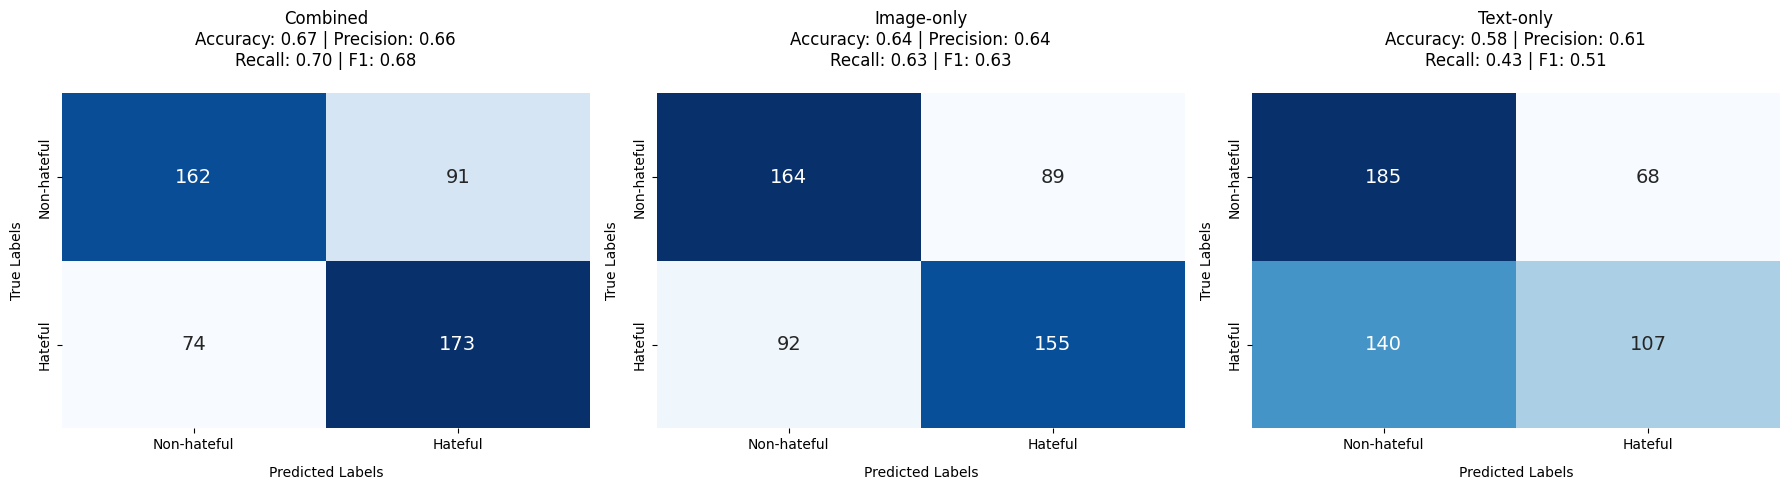

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediction from each model
models = {'Combined': combined_preds, 'Image-only': image_preds, 'Text-only': text_preds}

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Common settings for all heatmaps
heatmap_kwargs = {
    'annot': True,
    'fmt': 'd',
    'cmap': 'Blues',
    'xticklabels': ['Non-hateful', 'Hateful'],
    'yticklabels': ['Non-hateful', 'Hateful'],
    'cbar': False,
    'annot_kws': {'size': 14}
}

# Plot confusion matrices
for ax, (model_name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(test_labels, preds)
    sns.heatmap(cm, ax=ax, **heatmap_kwargs)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Add metrics to title
    ax.set_title(
        f"{model_name}\n"
        f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f} | F1: {f1:.2f}",
        pad=20
    )
    ax.set_xlabel('Predicted Labels', labelpad=10)
    ax.set_ylabel('True Labels', labelpad=10)

plt.tight_layout()
plt.show()


In [55]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

classifier.eval()

# Store predictions and labels
combined_logits = []
image_logits = []
text_logits = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = classifier(input_ids, attention_mask, pixel_values)
        
        #Each models output
        combined_logits.append(outputs['combined'].cpu())
        image_logits.append(outputs['image'].cpu())
        text_logits.append(outputs['text'].cpu())
        #Actual label
        test_labels.append(labels.cpu())

# Stack each batch output into one large tensor
combined_logits = torch.cat(combined_logits).numpy()  
image_logits = torch.cat(image_logits).numpy()
text_logits = torch.cat(text_logits).numpy()
test_labels = torch.cat(test_labels).numpy()  

# Convert logits to probabilities using sigmoid
combined_probs = torch.sigmoid(torch.tensor(combined_logits)).numpy()
image_probs = torch.sigmoid(torch.tensor(image_logits)).numpy()
text_probs = torch.sigmoid(torch.tensor(text_logits)).numpy()

# Convert probabilities to class predictions using threshold 0.5, could change this threshold
combined_preds = (combined_probs >= 0.5).astype(int)
image_preds = (image_probs >= 0.5).astype(int)
text_preds = (text_probs >= 0.5).astype(int)

# Function to print metrics
def print_metrics(name, probs, preds, labels):
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    print(f"{name} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("-" * 40)

# Print results
print("\nEvaluation Results:")
print_metrics("Combined", combined_probs, combined_preds, test_labels)
print_metrics("Image-only", image_probs, image_preds, test_labels)
print_metrics("Text-only", text_probs, text_preds, test_labels)



Evaluation Results:
Combined Model:
  Accuracy: 0.6920
  ROC AUC: 0.7658
----------------------------------------
Image-only Model:
  Accuracy: 0.6410
  ROC AUC: 0.7010
----------------------------------------
Text-only Model:
  Accuracy: 0.5860
  ROC AUC: 0.6683
----------------------------------------


In [56]:
# Convert probabilities to class predictions using threshold 0.5, could change this threshold
combined_preds = (combined_probs >= 0.1).astype(int)
image_preds = (image_probs >= 0.5).astype(int)
text_preds = (text_probs >= 0.5).astype(int)

# Function to print metrics
def print_metrics(name, probs, preds, labels):
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    print(f"{name} Model:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("-" * 40)

# Print results
print("\nEvaluation Results:")
print_metrics("Combined", combined_probs, combined_preds, test_labels)
print_metrics("Image-only", image_probs, image_preds, test_labels)
print_metrics("Text-only", text_probs, text_preds, test_labels)


Evaluation Results:
Combined Model:
  Accuracy: 0.7070
  ROC AUC: 0.7658
----------------------------------------
Image-only Model:
  Accuracy: 0.6410
  ROC AUC: 0.7010
----------------------------------------
Text-only Model:
  Accuracy: 0.5860
  ROC AUC: 0.6683
----------------------------------------


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediction from each model
models = {'Combined': combined_preds, 'Image-only': image_preds, 'Text-only': text_preds}

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Common settings for all heatmaps
heatmap_kwargs = {
    'annot': True,
    'fmt': 'd',
    'cmap': 'Blues',
    'xticklabels': ['Non-hateful', 'Hateful'],
    'yticklabels': ['Non-hateful', 'Hateful'],
    'cbar': False,
    'annot_kws': {'size': 14}
}

# Plot confusion matrices
for ax, (model_name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(test_labels, preds)
    sns.heatmap(cm, ax=ax, **heatmap_kwargs)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Add metrics to title
    ax.set_title(
        f"{model_name}\n"
        f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f} | F1: {f1:.2f}",
        pad=20
    )
    ax.set_xlabel('Predicted Labels', labelpad=10)
    ax.set_ylabel('True Labels', labelpad=10)

plt.tight_layout()
plt.show()
